In [23]:
import numpy as np
import pandas as pd
import mne
import os

import matplotlib.pyplot as plt
import seaborn as sns

# Single-Trial ERP Heatmap Visualization

## Method Overview

This script implements a **reaction time (RT)–aligned** approach to visualize single-trial event-related potentials (ERPs). Instead of using a fixed epoch window locked to stimulus onset, each trial is dynamically aligned so that:

- **Stimulus onset** is consistently placed at **t = –0.5 seconds** relative to the response trigger (i.e., the moment of button press),
- The **response time (RT)** varies across trials and defines the temporal distance between stimulus and response,
- All trials are **time-warped** such that they share a common temporal reference frame spanning from **t = –0.5 s (stimulus)** to **t = MAX_RT (maximum RT across all subjects)**.

This alignment ensures that:
- The **pre-stimulus baseline** (–0.5 s to 0 s) is preserved and consistent across trials,
- The **post-stimulus processing period** (0 s to RT) reflects the actual cognitive duration leading to a decision,
- The **post-response period** (RT to MAX_RT) is padded uniformly across trials, enabling direct comparison of neural dynamics even when RTs differ substantially.

---

# Code Walkthrough: Single-Trial ERP Extraction and RT-Aligned Heatmap Visualization

This script processes EEG and behavioral data from 20 subjects to create a **single-trial ERP heatmap**, where each trial is aligned based on its individual reaction time (RT). Below is a step-by-step explanation of what the code does, in the exact order of execution.


## 1. **Configuration and Data Loading**

- **Constants are defined**:
  - `SAMPLING_RATE_HZ = 500`: EEG sampling rate (500 Hz).
  - `DATA_ROOT_DIR` and `BEHAVIOR_DATA_PATH`: paths to preprocessed EEG (in BIDS/BrainVision format) and behavioral CSV file.
- **Behavioral data** (`behaviorData_low_1_final.csv`) is loaded into a pandas DataFrame (`behavior_df`). This file contains, for each trial, the subject ID and reaction time (RT) in seconds.
- **Maximum RT across all subjects** (`MAX_RT_SEC`) is computed. This determines the longest post-stimulus window needed to align all trials.

---

## 2. **Subject and Channel Setup**

- Subject directories follow the BIDS naming convention: `sub-A001`, `sub-A002`, ..., `sub-A020`.
- A **region of interest (ROI)** is defined using three channel indices: `[54, 36, 86]` (0-based). These correspond to specific scalp electrodes (e.g., parietal or occipital sites).
- An empty list `all_trials_records` is initialized to collect ERP data from every valid trial.

---

## 3. **Per-Subject Processing Loop**

For each subject:

### a. **Match behavioral and EEG data**
- Filter `behavior_df` to include only rows for the current subject.
- Load the subject’s EEG file (`.vhdr`) using `mne.io.read_raw_brainvision`.
- Convert EEG data from volts to microvolts (`/ 1e6`), resulting in a `(n_channels, n_samples)` array.

### b. **Compute ROI signal**
- Extract signals from the three ROI channels and average them across channels → yields a 1D time series (`roi_signal`) of length `n_samples`.

### c. **Extract response triggers**
- Use MNE’s annotation system to find events. The response event is identified by the annotation `'Stimulus/S  5'`.
- If no response triggers are found, skip the subject.
- Validate that the number of response triggers matches the number of behavioral trials. Raise an error if they differ.

### d. **Create a merged trial table**
- Combine behavioral RTs and EEG trigger sample indices into a DataFrame (`merged_trials`) with columns:
  - `subject_id`
  - `reaction_time_sec`
  - `trigger_sample` (sample index of the button press)

### e. **Compute dynamic epoch boundaries per trial**
Because RT varies per trial, the epoch window is **not fixed**. Instead:
- **Epoch start**: `trigger_sample – (RT + 0.5) × SAMPLING_RATE_HZ`  
  → This ensures that **stimulus onset** (which occurs 0.5 s before the trigger) is always at **time = –0.5 s** in the extracted segment.
- **Epoch end**: `trigger_sample + (MAX_RT_SEC – RT) × SAMPLING_RATE_HZ`  
  → This pads each trial so that **all trials end at the same absolute time** relative to the global maximum RT.

Both start and end indices are:
- Rounded to integers,
- Clamped to `[0, total_samples]` to avoid out-of-bounds access.

### f. **Extract ERP segment and store as a flat record**
For each trial:
- Slice the `roi_signal` between `epoch_start_sample` and `epoch_end_sample`.
- Skip the trial if the segment is invalid (e.g., start ≥ end).
- Store the trial as a dictionary with:
  - Metadata: `subject_id`, `reaction_time_sec`
  - One column per time point: `t_0`, `t_1`, `t_2`, ..., where each value is the ERP amplitude at that sample.
- Append this record to `all_trials_records`.

---

## 4. **Assemble and Clean Final DataFrame**

- Convert `all_trials_records` into a pandas DataFrame: `single_trial_erp_df`.
- Replace any `NaN` values (e.g., from unequal segment lengths) with `0`.  
  *(Note: In practice, all segments should have the same length due to the alignment logic, but this is a safety step.)*
- Identify ERP timepoint columns using the prefix `'t_'`.

---

## 5. **Prepare Data for Visualization**

- Sort trials by `reaction_time_sec` in **descending order** (longest RT at the top of the heatmap).
- Extract the ERP matrix: rows = trials, columns = time points → shape `(n_trials, n_timepoints)`.

---

## 6. **Plot the Heatmap**

- Use `seaborn.heatmap` with:
  - Colormap: `RdBu_r` (red = positive, blue = negative),
  - Centered at 0 µV,
  - Amplitude limits: `±15 µV`,
  - No tick labels on axes (for clarity with thousands of trials).

### Overlay 1: **Reaction time trajectory**
- For each trial, compute the **column index corresponding to RT**:
  - Since t = –0.5 s → column 0, then t = RT → column = `(RT + 0.5) × SAMPLING_RATE_HZ`.
- Plot these `(x, y)` points as a black line across trials.

### Overlay 2: **Time axis labels**
- Compute actual time (in seconds) for selected x-ticks (every 0.25 s).
- Convert time to column index: `(time + 0.5) × SAMPLING_RATE_HZ`.
- Set x-tick labels to show time relative to stimulus onset (e.g., `–0.50`, `0.00`, `0.25`, ...).

### Overlay 3: **Stimulus onset marker**
- Stimulus occurs at t = 0 s → column index = `0.5 × 500 = 250`.
- Draw a **dashed grey vertical line** at this position.

### Overlay 4: **Y-axis trial numbering**
- Label every 500th trial on the y-axis.
- Because the heatmap plots trial 0 at the **top**, but we want the bottom to represent "trial 0" in conventional plotting, the labels are flipped: `n_trials - 1 - y`.


In [24]:
# Configuration
SAMPLING_RATE_HZ = 500
DATA_ROOT_DIR = '../data/preprocessData'
BIDS_FILENAME_LABELS = ['_task-randomDot', '_eeg']
BEHAVIOR_DATA_PATH = '../data/behaviorData_low_1_final.csv'

# Load behavioral data
behavior_df = pd.read_csv(BEHAVIOR_DATA_PATH)
MAX_RT_SEC = behavior_df['RT'].max()  # Maximum reaction time across all subjects (in seconds)

# Channel indices for ROI (0-based indexing)
ROI_CHANNEL_INDICES = [54, 36, 86]

# Subject identifiers
subject_dirs = [f'sub-A{i:03d}' for i in range(1, 21)]
subject_ids_behavior = [f'A{i:03d}' for i in range(1, 21)]

# Container for all single-trial ERP data
all_trials_records = []

for subject_dir, subject_id in zip(subject_dirs, subject_ids_behavior):
    print(f"Processing {subject_dir}...")

    # Filter behavioral data for current subject
    subject_behavior = behavior_df[behavior_df.iloc[:, 0] == subject_id].reset_index(drop=True)

    # Load EEG data
    eeg_file_path = os.path.join(
        DATA_ROOT_DIR,
        subject_dir,
        'eeg',
        subject_dir + BIDS_FILENAME_LABELS[0] + BIDS_FILENAME_LABELS[1] + '.vhdr'
    )
    raw_eeg = mne.io.read_raw_brainvision(eeg_file_path, preload=True)
    eeg_data_microvolts = raw_eeg.get_data() / 1e6  # Convert to µV; shape: (n_channels, n_samples)
    total_samples = eeg_data_microvolts.shape[1]

    # Compute region-of-interest (ROI) signal: average over selected channels
    roi_signal = eeg_data_microvolts[ROI_CHANNEL_INDICES, :].mean(axis=0)  # Shape: (n_samples,)

    # Extract response triggers from annotations
    events, event_id = mne.events_from_annotations(raw_eeg)
    response_event_key = 'Stimulus/S  5'
    if response_event_key not in event_id:
        print(f"Warning: No response triggers found for {subject_dir}. Skipping.")
        continue

    response_events = events[events[:, 2] == event_id[response_event_key]]

    # Validate trial count consistency
    if len(response_events) != len(subject_behavior):
        raise ValueError(f"Trial count mismatch in {subject_dir}: "
                         f"EEG triggers ({len(response_events)}) ≠ behavior rows ({len(subject_behavior)})")

    # Merge behavioral and trigger data
    merged_trials = pd.DataFrame({
        'subject_id': subject_behavior['subj'].values,
        'reaction_time_sec': subject_behavior['RT'].values,
        'trigger_sample': response_events[:, 0]
    })

    # Compute epoch boundaries per trial
    # Epoch starts at: trigger - (RT + 0.5 sec) → aligns t = -0.5 sec to stimulus onset
    # Epoch ends at:   trigger + (MAX_RT - RT) → ensures all trials end at same absolute time relative to max RT
    merged_trials['epoch_start_sample'] = np.round(
        np.maximum(0, merged_trials['trigger_sample'] - (merged_trials['reaction_time_sec'] + 0.5) * SAMPLING_RATE_HZ)
    ).astype(int)

    merged_trials['epoch_end_sample'] = np.round(
        np.minimum(total_samples, merged_trials['trigger_sample'] + (MAX_RT_SEC - merged_trials['reaction_time_sec']) * SAMPLING_RATE_HZ)
    ).astype(int)

    # Extract ERP segment for each trial
    for _, trial_row in merged_trials.iterrows():
        start_idx = trial_row['epoch_start_sample']
        end_idx = trial_row['epoch_end_sample']

        # Skip invalid segments
        if start_idx >= end_idx or start_idx < 0 or end_idx > len(roi_signal):
            continue

        erp_segment = roi_signal[start_idx:end_idx]

        # Build trial record: metadata + timepoint amplitudes
        trial_record = {
            'subject_id': trial_row['subject_id'],
            'reaction_time_sec': trial_row['reaction_time_sec']
        }
        for time_idx, amplitude in enumerate(erp_segment):
            trial_record[f't_{time_idx}'] = amplitude

        all_trials_records.append(trial_record)

# Assemble final DataFrame
single_trial_erp_df = pd.DataFrame(all_trials_records)
print("Final ERP DataFrame shape:", single_trial_erp_df.shape)

Processing sub-A001...
Extracting parameters from ../data/preprocessData/sub-A001/eeg/sub-A001_task-randomDot_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 491752  =      0.000 ...   983.504 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
Processing sub-A002...
Extracting parameters from ../data/preprocessData/sub-A002/eeg/sub-A002_task-randomDot_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 461225  =      0.000 ...   922.450 secs...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
Processing sub-A003...
Extracting parameters from ../data/preprocessData/sub-A003/eeg/sub-A003_task-randomDot_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 449383  =      0.000 ...   8

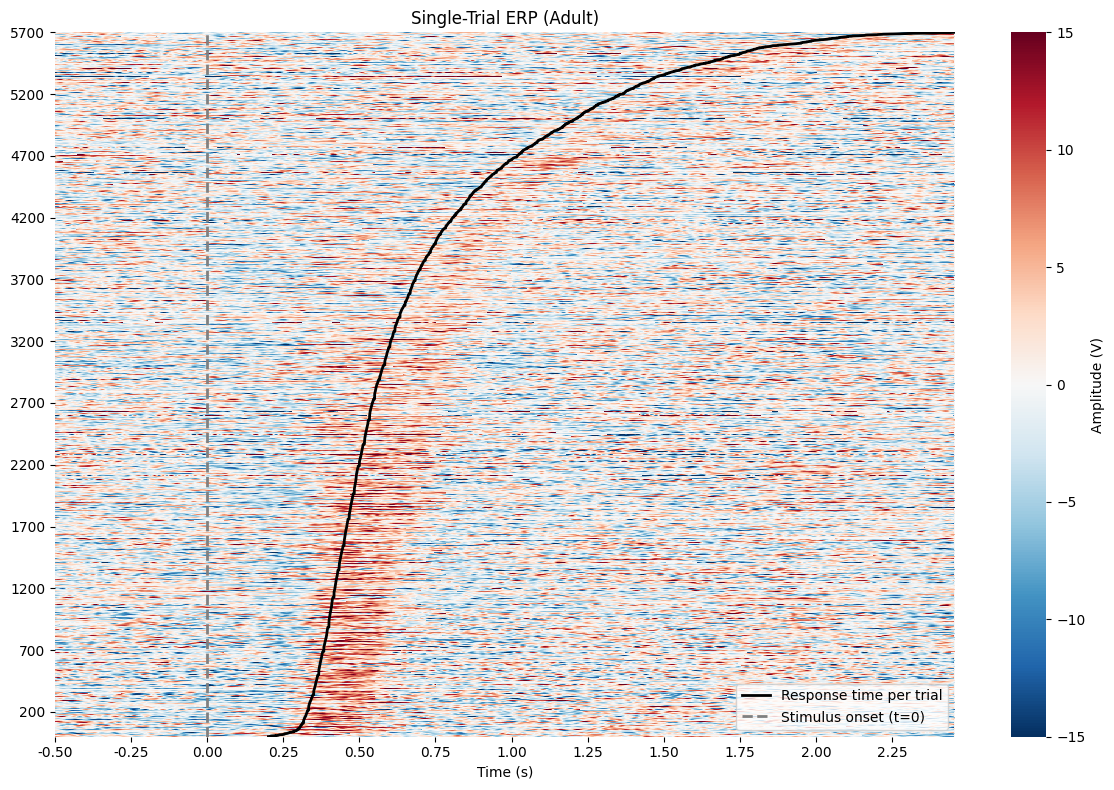

In [25]:
# Clean data: replace NaNs with 0 (assumes missing ERP samples are negligible)
single_trial_erp_df = single_trial_erp_df.fillna(0)

# Identify ERP timepoint columns
erp_timepoint_columns = [col for col in single_trial_erp_df.columns if col.startswith('t_')]

# Sort trials by reaction time (longest RT at top of heatmap)
sorted_df = single_trial_erp_df.sort_values('reaction_time_sec', ascending=False).reset_index(drop=True)
erp_matrix = sorted_df[erp_timepoint_columns].values
n_trials, n_timepoints = erp_matrix.shape

# Create heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    erp_matrix,
    cmap='RdBu_r',
    center=0,
    xticklabels=False,
    yticklabels=False,
    vmin=-15,
    vmax=15,
    cbar_kws={'label': 'Amplitude (V)'}
)

# --- 1. Overlay reaction time trajectory ---
rt_array = sorted_df['reaction_time_sec'].to_numpy()
# Time axis: t = -0.5 sec corresponds to column index 0
# Therefore, RT (relative to stimulus) occurs at: t = RT → column = (RT + 0.5) * sampling_rate
rt_x_positions = (rt_array + 0.5) * SAMPLING_RATE_HZ
y_positions = np.arange(n_trials)  # y=0 at top, y=n_trials-1 at bottom
ax.plot(rt_x_positions, y_positions, color='black', linewidth=2, label='Response time per trial')

# --- 2. Set x-axis time labels ---
# Total duration covered: from t = -0.5 sec to t = (n_timepoints / SAMPLING_RATE_HZ) - 0.5 sec
time_vector_sec = np.arange(-0.5, (n_timepoints / SAMPLING_RATE_HZ) - 0.5 + 1e-9, 0.25)
x_tick_indices = ((time_vector_sec + 0.5) * SAMPLING_RATE_HZ).astype(int)

# Ensure indices are within bounds
valid_ticks = (x_tick_indices >= 0) & (x_tick_indices < n_timepoints)
ax.set_xticks(x_tick_indices[valid_ticks])
ax.set_xticklabels([f"{t:.2f}" for t in time_vector_sec[valid_ticks]])

# --- 3. Set y-axis trial labels ---
# Label every 500 trials
y_tick_step = 500
y_tick_positions = np.arange(0, n_trials, y_tick_step)

# For correct visual alignment with "trial 0 at bottom",
# we plot y = n_trials - 1 - i, but since we want labels to reflect actual trial order from bottom,
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(n_trials - 1 - y_tick_positions)  # Trial index as shown (0 = first row = top)

# --- 4. Mark stimulus onset (t = 0) ---
t0_column_index = int(0.5 * SAMPLING_RATE_HZ)  # Because t = -0.5 → col 0, so t=0 → col 250
ax.axvline(x=t0_column_index, color='grey', linewidth=2, linestyle='--', label='Stimulus onset (t=0)')

# --- 5. Finalize plot ---
ax.set_xlabel('Time (s)')
ax.set_title('Single-Trial ERP (Adult)')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()